# CMP

1. Naredite robota podajnega in zajemite trajektorijo v prostoru sklepov na 100 Hz.

2. Izrišite zajeto trajektorijo.

3. Trajektorijo zapišite z uporabo DMP-jev - kodirajte v DMP.

4. Trajektorijo dekodirajte iz DMP-jev in jo narišite na isti plot kot osnovno, zajeto trajektorijo. **Pozor! robot ima 7 sklepov!**

5. Naredite robota togega in izvedite zakodirano trajektorijo (narisite napoko izvedbe na nov graf)

6. Med izvajanjem zajemite krmilne navore v sklepih brez gravitacije (r.state.tau_J_d)

7. Zapisite navore kot TP (torque primitives)

8. Izrisite in primerjajte zajete in dekodirane navore

9. Naredite robota podajnega 

10. Izvedite zajeto pozicijsko trajetorijo (DMP) - pozor zacetna lega

11. ... in izrisite napako izvedbe na isti graf napake kot prej

12. Izvedite CMP (DMP in TP); poglejte vhode za r.GoTo_q

13. ... in izrisite napako izvedbe na isti graf napake kot prej

14. Preizkusite togost robota ob izvedbi CMPja

15. Pogovorite se o CMPjih in napakah z asistentom

16. Napisite celosten robotski program, ki iz zacetne lege najprej pobere rocko in jo premakne na koncno lego (DMP togo, DMP podajno, CMP podajno) in primerjajte izvedbe (napake)


In [26]:
import rospy
import inspect
import numpy as np
import time
from robotblockset.graphics import plotjtraj
import matplotlib.pyplot as plt
from utils import SoftSetJointCompliance
from dmp import DMP
from tp import*



from robotblockset.ros.grippers_ros import PandaGripper
from importlib import reload
import example_data_recorder
#reload(example_data_recorder)
from utils import SoftSetJointCompliance
ns = "pingvin_2"
rospy.init_node(ns)
from robotblockset.ros.franka import panda_ros
r = panda_ros(ns=ns, control_strategy="JointImpedance", init_node=False)
g = PandaGripper(namespace=ns,robot=r)

Make sure that ROS node is initialized outside
Panda::Initialized
Panda:Gripper:ROS:Created


In [82]:
r.ErrorRecovery()

Panda::Recovering from errors:
 ['cartesian_reflex']
Panda::Attempting to change robot mode from 4


0

In [ ]:
r.SetJointCompliant()

In [7]:
def record_robot_state(robot, frequency, duration):
    interval = 1.0 / frequency
    
    N=int(frequency*duration)
    tt = np.zeros((N,1))
    qt = np.zeros((N,r.nj))
    dqt = np.zeros((N,r.nj))
    xt = np.zeros((N,r.nj))

    i = 0
    start_time = time.monotonic()
    end_time = start_time + duration
    
    last_update = time.monotonic()

    while time.monotonic() <= end_time+interval and i < N:
        t = time.monotonic()
        if t - last_update >= interval:
            
            # Get robot state
            state = robot.GetState()
            xt[i] = robot.x
            tt[i] = t-start_time
            qt[i] = robot.q
            dqt[i] = robot.qdot

            # Update the last recorded time
            last_update = t
            i += 1
        
    return xt, tt, qt, dqt, i, N   

In [37]:
r.SetJointCompliant()
print("START")
xt, tt, qt, dqt, i, N = record_robot_state(r,100,5)

print("STOP")

:Joint compliance changed 
Stiff:[0. 0. 0. 0. 0. 0. 0.]
Damp:[0. 0. 0. 0. 0. 0. 0.]
START
STOP


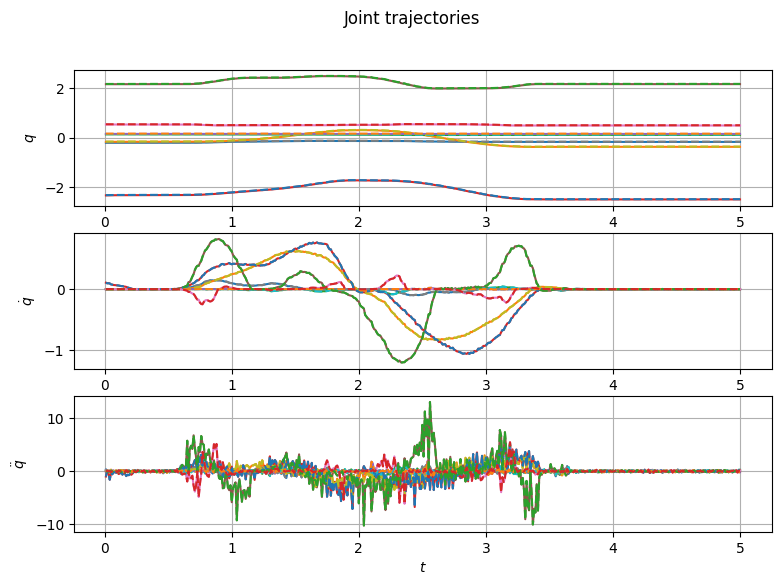

In [38]:
fig, ax = plt.subplots(3, 1, figsize=(9, 6))
fig.suptitle('Joint trajectories')
plotjtraj(tt, qt, dqt, ax=ax);
plotjtraj(tt, qt+0.01, dqt, ax=ax, linestyle="--");

In [39]:
r.ResetCurrentTarget()
SoftSetJointCompliance(r,r._franka_default.JointCompliance.K,4)

:Joint compliance changed 
Stiff:[1200. 1200. 1200. 1200.    0.    0.    0.]
Damp:[25 25 25 25 10 10 10]


In [17]:
r.JMove(qt[0],3)
N=np.size(qt,0)
for q, qdot, tm in zip(qt, dqt, np.diff(tt, axis=0)): 
    # Call the GoTo_q function
    r.GoTo_q(q,qdot,np.zeros(7),0)
    # time.sleep(1/100.)
    time.sleep(tm[0])

In [42]:
d = DMP(qt.copy(),np.squeeze(tt.copy()),vel_data=dqt.copy(),num_weights=25)

In [43]:
trj_dec,t_dec=d.decode()

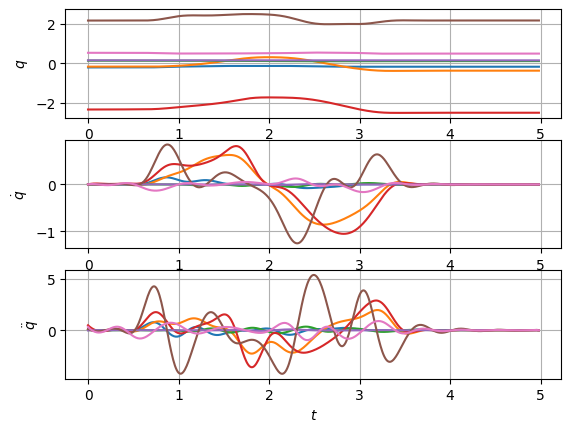

In [44]:
plotjtraj(qt=trj_dec, t=t_dec);

In [45]:
r.JMove(trj_dec[0],5)
i = 0
trq = np.zeros_like(trj_dec)
for q in trj_dec: 
    r.GoTo_q(q,np.zeros(7),np.zeros(7),0)
    trq[i] = np.array(r.state.tau_J_d) #new line to store trqs
    i += 1
    time.sleep(1/100.)

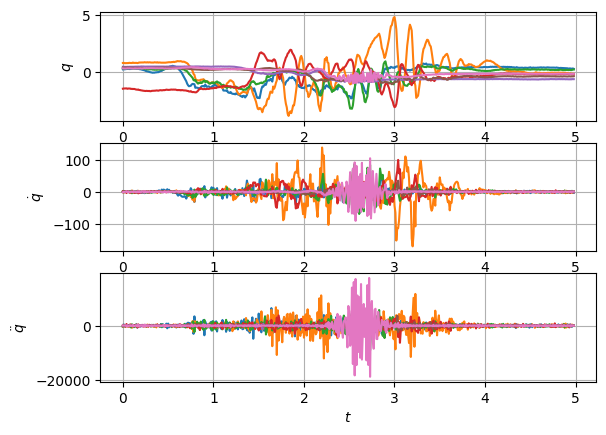

In [24]:
plotjtraj(qt=trq, t=t_dec);

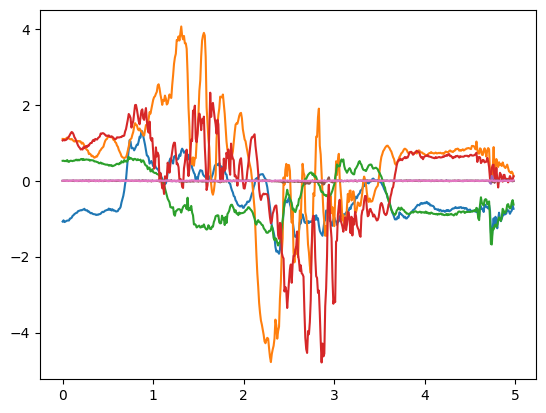

In [46]:
plt.plot(t_dec, trq)
plt.show()

In [53]:
print(trq.shape)

(499, 7)


In [54]:
trq1 = (np.vstack((np.zeros((1,7)),trq)))


In [55]:
print(trq1.shape)

(500, 7)


In [93]:
tp = TP(trq1.copy(), np.squeeze(tt.copy()), num_weights=75)

In [94]:
trq_dec, trq_t = tp.decode()

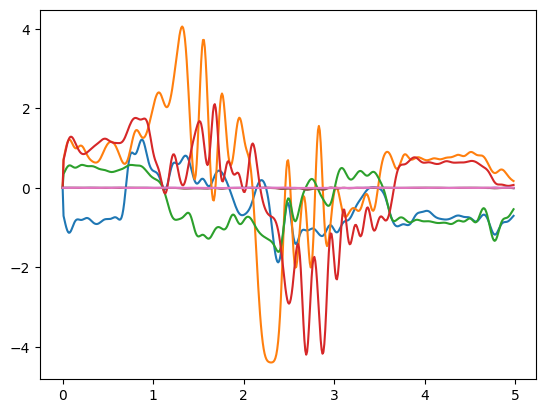

In [95]:
plt.plot(trq_t, trq_dec)
plt.show()

In [79]:
#r.ResetCurrentTarget()
#SoftSetJointCompliance(r,10,4)
r.SetJointSoft(0.01)

:Joint compliance changed 
Stiff:[12.  12.  12.  12.   2.5  2.5  1. ]
Damp:[0.25 0.25 0.25 0.25 0.1  0.1  0.1 ]


In [96]:

r.ResetCurrentTarget()
SoftSetJointCompliance(r,r._franka_default.JointCompliance.K,4)
r.JMove(trj_dec[0],5)
r.SetJointSoft(0.01)
i = 0
qTest = np.zeros_like(trj_dec)
for q in trj_dec: 
    r.GoTo_q(q,np.zeros(7),np.zeros(7),0)
    qTest[i] = np.array(r.q) #new line to store qs
    i += 1
    time.sleep(1/100.)

:Joint compliance changed 
Stiff:[12.  12.  12.  12.   2.5  2.5  1. ]
Damp:[25 25 25 25 10 10 10]
:Joint compliance changed 
Stiff:[12.  12.  12.  12.   2.5  2.5  1. ]
Damp:[0.25 0.25 0.25 0.25 0.1  0.1  0.1 ]


In [ ]:
r.ErrorRecovery()

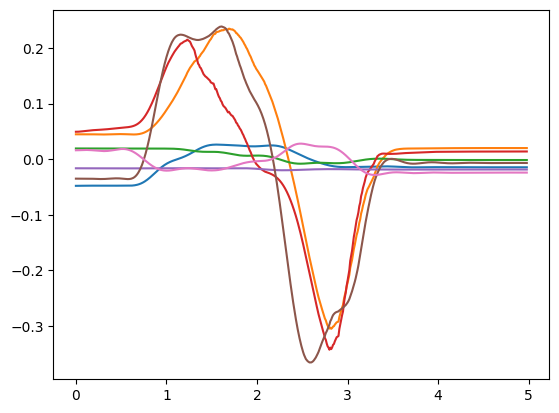

In [99]:
plt.plot(t_dec, trj_dec-qTest)
plt.show()

In [88]:
print(trq_dec.shape)
print(trj_dec.shape)

(499, 7)
(499, 7)
ERROR! Session/line number was not unique in database. History logging moved to new session 105


In [105]:
r.ResetCurrentTarget()
SoftSetJointCompliance(r,r._franka_default.JointCompliance.K,4)
r.JMove(trj_dec[0],5)
r.SetJointSoft(0.01)

i = 0
qTestCMP = np.zeros_like(trj_dec)
for q in trj_dec: 
    r.GoTo_q(q,np.zeros(7),trq_dec[i],0)
    qTestCMP[i] = np.array(r.q) #new line to store qs
    i += 1
    time.sleep(1/100.)

:Joint compliance changed 
Stiff:[12.  12.  12.  12.   2.5  2.5  1. ]
Damp:[25 25 25 25 10 10 10]
:Joint compliance changed 
Stiff:[12.  12.  12.  12.   2.5  2.5  1. ]
Damp:[0.25 0.25 0.25 0.25 0.1  0.1  0.1 ]


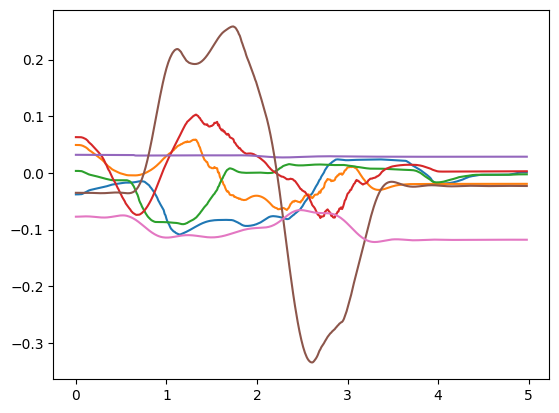

In [106]:
plt.plot(t_dec, trj_dec-qTestCMP)
plt.show()